In [1]:
import argparse
import gc
import hashlib
import itertools
import logging
import math
import os
import threading
import warnings
from pathlib import Path
from typing import Optional
import psutil
import json

import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import datasets
import diffusers
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, UNet2DConditionModel
from diffusers import DDPMScheduler, PNDMScheduler, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version
from diffusers.utils.import_utils import is_xformers_available
from huggingface_hub import HfFolder, Repository, whoami

from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig, CLIPFeatureExtractor

import sys
os.chdir("/home/yxiu/Code/oft-butterfly/oft-dreambooth")
sys.path.append("./peft/src")
from peft import (
    PeftModel, LoraConfig, OFTConfig, BOFTConfig, 
    get_peft_model_state_dict, set_peft_model_state_dict,)

# Will error if the minimal version of diffusers is not installed. Remove at your own risks.
check_min_version("0.10.0.dev0")

logger = get_logger(__name__)

MODEL_NAME = "stabilityai/stable-diffusion-2-1"  # "stabilityai/stable-diffusion-2-1-base"
# MODEL_NAME="runwayml/stable-diffusion-v1-5"
INSTANCE_PROMPT = "a photo of sks dog"
base_path = "/home/yxiu/Code/oft-butterfly/oft-dreambooth"
picked_epoch = 2000


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/yxiu/miniconda3/envs/OPT/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA SETUP: CUDA runtime path found: /home/yxiu/miniconda3/envs/OPT/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /home/yxiu/miniconda3/envs/OPT/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


Detected CUDA files, patching ldflags
Emitting ninja build file /tmp/build.ninja...
Building extension module fbd_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module fbd_cuda...
No modifications detected for re-loaded extension module fbd_cuda, skipping build step...
Loading extension module fbd_cuda...


In [2]:
def get_lora_sd_pipeline(
    ckpt_dir, base_model_name_or_path=None, dtype=torch.float32, device="cuda", adapter_name="default"
):

    if base_model_name_or_path is None:
        raise ValueError("Please specify the base model name or path")

    pipe = StableDiffusionPipeline.from_pretrained(
        base_model_name_or_path, torch_dtype=dtype, requires_safety_checker=False
    ).to(device)
    
    load_adapter(pipe, ckpt_dir, adapter_name)

    if dtype in (torch.float16, torch.bfloat16):
        pipe.unet.half()
        pipe.text_encoder.half()

    pipe.to(device)
    return pipe


def load_adapter(pipe, ckpt_dir, adapter_name="default"):
    
    unet_sub_dir = os.path.join(ckpt_dir, f"unet/{picked_epoch}", adapter_name)
    text_encoder_sub_dir = os.path.join(ckpt_dir, f"text_encoder/{picked_epoch}", adapter_name)
    
    if isinstance(pipe.unet, PeftModel):
        pipe.unet.load_adapter(unet_sub_dir, adapter_name=adapter_name)
    else:
        pipe.unet = PeftModel.from_pretrained(pipe.unet, unet_sub_dir, adapter_name=adapter_name)
        
    if os.path.exists(text_encoder_sub_dir):
        if isinstance(pipe.text_encoder, PeftModel):
            pipe.text_encoder.load_adapter(text_encoder_sub_dir, adapter_name=adapter_name)
        else:
            pipe.text_encoder = PeftModel.from_pretrained(pipe.text_encoder, unet_sub_dir, adapter_name=adapter_name)
    

def set_adapter(pipe, adapter_name):
    pipe.unet.set_adapter(adapter_name)
    if isinstance(pipe.text_encoder, PeftModel):
        pipe.text_encoder.set_adapter(adapter_name)


def merging_lora_with_base(pipe, ckpt_dir, adapter_name="default"):
    unet_sub_dir = os.path.join(ckpt_dir, "unet")
    text_encoder_sub_dir = os.path.join(ckpt_dir, "text_encoder")
    if isinstance(pipe.unet, PeftModel):
        pipe.unet.set_adapter(adapter_name)
    else:
        pipe.unet = PeftModel.from_pretrained(pipe.unet, unet_sub_dir, adapter_name=adapter_name)
    pipe.unet = pipe.unet.merge_and_unload()

    if os.path.exists(text_encoder_sub_dir):
        if isinstance(pipe.text_encoder, PeftModel):
            pipe.text_encoder.set_adapter(adapter_name)
        else:
            pipe.text_encoder = PeftModel.from_pretrained(
                pipe.text_encoder, text_encoder_sub_dir, adapter_name=adapter_name
            )
        pipe.text_encoder = pipe.text_encoder.merge_and_unload()

    return pipe


def create_weighted_lora_adapter(pipe, adapters, weights, adapter_name="default"):
    pipe.unet.add_weighted_adapter(adapters, adapter_name)
    if isinstance(pipe.text_encoder, PeftModel):
        pipe.text_encoder.add_weighted_adapter(adapters, weights, adapter_name)

    return pipe

In [3]:
peft_type = "boft"

In [4]:
%%time
pipe = get_lora_sd_pipeline(os.path.join(base_path, f"data/output/{peft_type}"), MODEL_NAME, adapter_name="dog")

CPU times: user 23.7 s, sys: 3.76 s, total: 27.5 s
Wall time: 12.3 s


In [5]:
%%time
load_adapter(pipe, os.path.join(base_path, f"data/output/{peft_type}"), adapter_name="dog2")
load_adapter(pipe, os.path.join(base_path, f"data/output/{peft_type}"), adapter_name="dog3")
load_adapter(pipe, os.path.join(base_path, f"data/output/{peft_type}"), adapter_name="duck_toy")

CPU times: user 57.5 s, sys: 3.11 s, total: 1min
Wall time: 17 s


In [6]:
%%time
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2

pipe = create_weighted_lora_adapter(pipe, ["dog", "duck_toy"], [0.50, 0.50], adapter_name="new_obj")

CPU times: user 21.5 s, sys: 1.69 s, total: 23.2 s
Wall time: 8.51 s


In [7]:
set_adapter(pipe, adapter_name="new_obj")

  0%|          | 0/50 [00:00<?, ?it/s]

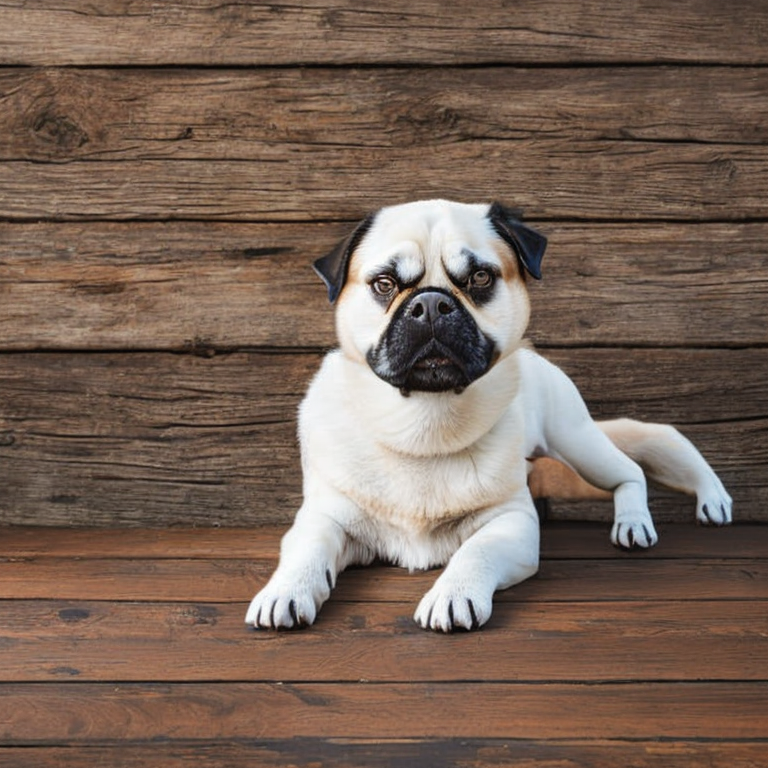

In [8]:
prompt = "qwe dog is on a wooden table"
negative_prompt = "low quality, blurry, unfinished"
# for i in range(20):
image = pipe(prompt, num_inference_steps=50, guidance_scale=7, negative_prompt=negative_prompt).images[0]
image
# image.save(f"./data/output/mix/{i}.png")
# unet = UNet2DConditionModel.from_pretrained(args.pretrained_model_name_or_path, subfolder="unet", revision=args.revision)
# config = OFTConfig(oft_r=32, target_modules=UNET_TARGET_MODULES, oft_dropout=0.1, bias="none", oft_bias_fit=False)
# config = BOFTConfig(boft_block_size=0, boft_block_num=32, boft_n_butterfly_factor=5, target_modules=UNET_TARGET_MODULES, boft_dropout=0.1, bias="none", boft_bias_fit=False)
# config = LoraConfig(r=32, lora_alpha=27, target_modules=UNET_TARGET_MODULES, lora_dropout=0.1, bias="none")